### Exploring Clustering with Online Retail data from UCI
MSDS 7331 Data Mining Lab 3

Authors: Laura Ludwig, Anthony Schams, Josh Balson, David Stroud

This is a trans-national data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The selection of attributes plays an important role in good clustering analysis. Therefore, we will cluster the RPM (Recency, Frequency, Monetary) variables using the Online Retail Data Set from the UCI Machine Learning Repository.

RPM analysis has historically been used to analyze large retail data sets of customer purchases to analyze retailer business activity. To accomplish this task, we will use clustering techniques to identify segments in the purchasing patterns to identify common characteristics. Since our data set is primarily composed of retailers purchasing from a wholesaler, it is in our best interest to identify the retailers purchasing patterns.

Market segmentation allows a business to analyze, understand and draw good market segements from the customers purchasing behavior. Clustering analysis will allow us to identify segments of retail purchases who have certain characteristics. Idenfication of these paterns give us an information advantage, thus allowing us to act on better solutions for our clients.

Once the data set has been properly cleaned, clustering intends to identify whether customers can be segmented meaningfully in the view of recency, frequency and monetary values. The k-means clustering algorithm was employed specifically for this purpose.

### Attribute Information:
 - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
 - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
 - Description: Product (item) name. Nominal.
 - Quantity: The quantities of each product (item) per transaction. Numeric.
 - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
 - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
 - Country: Country name. Nominal, the name of the country where each customer res

In [68]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [69]:
#df = pd.read_excel('OnlineRetail.xlsx')
df = pd.read_csv('OnlineRetail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [70]:
# Note that we have more than 540,000 instances
# and eight variables with the original dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [71]:
# Remove all of the cancelled orders
# df = df.loc[(~df['InvoiceNo'].str.startswith('C'))] 
# Commenting out because do do this differently later in the Missing Data section

In [72]:
# We go from approximately 541,000 orders to 
# 532,000 orders, when we account for
# cancellations
# df.info()

RFM Score Calculations:
 - RECENCY (R): Days since last purchase
 - FREQUENCY (F): Total number of purchases
 - MONETARY VALUE (M): Total money this customer spent  
 
The purpose of uing the RFM analysis is to reduce the data set into attributes that may explain the business activities of the retailers.

In [73]:
# Note that we have 38 unique countries in date set# 
df.Country.nunique()

38

In [74]:
# Breakdown of each unique country
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Malta', 'RSA'], dtype=object)

In [75]:
# We have a total of 4,339 customer id's ~ 3,921 are from the United Kingdom
df.CustomerID.nunique()

4372

In [76]:
# List of Countries, by CustomerID in ascending order# List o 
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


More than 90% of the customers are from the United Kingdom

In [77]:
# Restrict data set to the United Kingdom only# 
df = df.loc[df['Country'] == 'United Kingdom']

### Missing Data
Notice that 133,277 values are missing from CustomerID. Since the analysis is based on customers, we will remove those with missing values. Thus, we are eliminating approximately twenty-five percent of the data set.

We are now down to 408,632 of the original 541,909 values

In [78]:
# Check whether there are missing values in each column
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [79]:
df = df[pd.notnull(df['CustomerID'])]

In [80]:
df.Quantity.min()

-80995

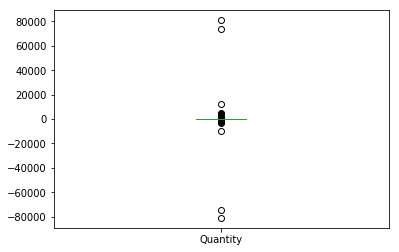

In [81]:
df.Quantity.plot(kind='box')

In [82]:
df.loc[df['Quantity'].apply(pd.to_numeric, errors='coerce').abs()>60000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/11 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/11 10:17,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/11 9:15,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/11 9:27,2.08,16446.0,United Kingdom


In [83]:
# Create two dataframes that represent the positive transactions and negative (cancellation) transactions separately so we can combine them# Create 
df_pos = df.loc[df['Quantity']>0]
df_neg = df.loc[df['Quantity']<0]
df_neg.loc[:, 'Quantity'] = df_neg['Quantity'] * -1

# This takes all of the transactions that are positive, and matches them with any negative transactions in a new set of columns.
df_t = df_pos.merge(df_neg, how = 'left', on=['StockCode','Quantity','CustomerID'])

In [84]:
# This takes just the rows where there is a transaction and no corresponding cancellation (as best as we can find)
df_t1 = df_t.loc[df_t['InvoiceNo_y'].isnull()]
df_t2 = df_t1.iloc[:,0:8]
df_t2.columns = df.columns
df_t2.describe()

,Quantity,UnitPrice,CustomerID
count,349809.000000,349809.000000,349809.000000
mean,11.455074,2.879932,15550.102433
std,45.575768,8.295879,1594.121433
min,1.000000,0.000000,12747.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.850000,15524.000000
75%,12.000000,3.750000,16931.000000
max,12540.000000,2033.100000,18287.000000


In [85]:
# There are no more negative quantities, and we have the resulting shape. 
df = df_t2
df.shape

(349809, 8)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349809 entries, 0 to 354722
Data columns (total 8 columns):
InvoiceNo      349809 non-null object
StockCode      349809 non-null object
Description    349809 non-null object
Quantity       349809 non-null int64
InvoiceDate    349809 non-null object
UnitPrice      349809 non-null float64
CustomerID     349809 non-null float64
Country        349809 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 24.0+ MB


The remaining dataset, having removed the orders that were cancelled and the cancelations, have 349,809 order line entries with eight different variables.

In [87]:
# Check the unique values for each column
def unique_counts(df):
    for i in df.columns:
        count = df[i].nunique()
        print(i, ":", count)
unique_counts(df)

InvoiceNo : 16424
StockCode : 3639
Description : 3835
Quantity : 282
InvoiceDate : 15412
UnitPrice : 387
CustomerID : 3910
Country : 1


In [88]:
# add a column for total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [89]:
# We now have a clean data set and are ready to 
# proceed with placing the data in RPM format
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349809 entries, 0 to 354722
Data columns (total 9 columns):
InvoiceNo      349809 non-null object
StockCode      349809 non-null object
Description    349809 non-null object
Quantity       349809 non-null int64
InvoiceDate    349809 non-null object
UnitPrice      349809 non-null float64
CustomerID     349809 non-null float64
Country        349809 non-null object
TotalPrice     349809 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 26.7+ MB


## Feature Engineering

When you use domain knowledge to choose which data metrics to use as input features into a machine learning algorithm, you are using feature engineering. Feature engineering plays a key role in k-means clustering by capturing the variability of the data that is essential for the algorithm to find all of the natural-occurring groups. 


### Structure data set according to RFM analysis

In [90]:
# Find the first and last order dates in the data# Find t 
# to satisfy the Frequency requirements
df['InvoiceDate'].min() # min date

'1/10/11 10:32'

In [91]:
df['InvoiceDate'].max() # max date

'9/9/11 9:52'

In [92]:
# In order to create the frequency table, a point in time
# must be calculated. Since the last invoice date is 2011-12-09
# we will use 2011-12-10 to calculate Recency
import datetime as dt
NOW = dt.datetime(2011,12,10)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [158]:
# Create RFM table
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x:
                                        (NOW - x.max()).days,
                                        'InvoiceNo': lambda x: x.nunique(),
                                        'TotalPrice': lambda x: x.sum()})
rfmTable['AverageOrderSize']= rfmTable['TotalPrice']/rfmTable['InvoiceNo']

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                        'InvoiceNo': 'frequency',
                        'TotalPrice': 'monetary_value',
                        'AverageOrderSize': 'average_order'},
               inplace=True)

In [159]:
rfmTable.head()

,recency,frequency,monetary_value,average_order
CustomerID,,,,
12747.0,2,11,4196.01,381.455455
12748.0,0,202,30559.46,151.284455
12749.0,3,5,4090.88,818.176000
12820.0,3,4,942.34,235.585000
12821.0,214,1,92.72,92.720000


#### Translation:
Customer 12747.0 has a Frequency:11, Monetary value of $4,196.01 and Recency of 2 days. This customer has made several purchases and their last purchase was two days before the end of the period of interest. 

Customer 12821.0 has a Frequency 1 , Monetary value of $92.72 and Recency of 214 days. The customer has made only one transaction, and it was 214 days ago.

In [95]:
# Sample viewing of a customer
#sample_customer = rfmTable[rfmTable['recency']==214]
#sample_customer

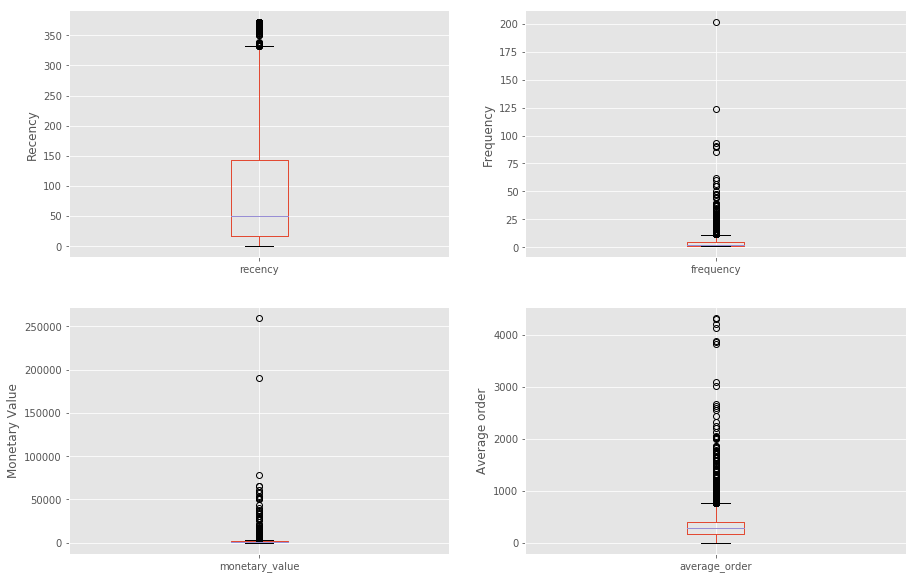

In [162]:
# Look at box plots of variables
plt.figure(figsize = (15,10))
plt.subplot(221)
rfmTable.recency.plot(kind='box')
plt.ylabel('Recency')
plt.subplot(222)
rfmTable.frequency.plot(kind='box')
plt.ylabel('Frequency')
plt.subplot(223)
rfmTable.monetary_value.plot(kind='box')
plt.ylabel('Monetary Value')
plt.subplot(224)
rfmTable.average_order.plot(kind='box')
plt.ylabel('Average order')


plt.show()

In [97]:
# get the 80% of the monetary value
pareto_cutoff = rfmTable['monetary_value'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  5430510.04


### Create a customers rank table that ranks customers by how much they purchased¶

In [98]:
customers_rank  = rfmTable
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['monetary_value'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,recency,frequency,monetary_value,Rank
CustomerID,,,,
12747.0,2,11,4196.01,272.0
12748.0,0,202,30559.46,22.0
12749.0,3,5,4090.88,285.0
12820.0,3,4,942.34,1489.0
12821.0,214,1,92.72,3781.0


### Top Customers
 - Note, there is a total of 3,910 Customer ID's

In [100]:
customers_rank.sort_values('Rank',ascending=True)

,recency,frequency,monetary_value,Rank
CustomerID,,,,
18102.0,0,60,259657.30,1.0
17450.0,8,45,189767.53,2.0
17511.0,2,30,77682.38,3.0
16684.0,4,27,65767.48,4.0
14096.0,4,17,65164.79,5.0
13694.0,3,48,61403.14,6.0
15311.0,0,90,58949.31,7.0
13089.0,2,93,57573.28,8.0
15061.0,3,48,54391.94,9.0


In [101]:
# get the top 20% of customers
top_20percent = 3910 * 20 / 100
top_20percent

782.0

In [51]:
# sum the monetary values over the customer with rank <=782

In [102]:
top_20percent_revenue = customers_rank[customers_rank['Rank'] <= 782]['monetary_value'].sum()
top_20percent_revenue

4873025.9209999945

Pareto principle is basically applicable to this data set

 - The 80% of total revenue is 5430510.04 
 - Top 20% of 4873025.92

### RFM Quartiles
We will create customer segments from the RFM model and assign a score from 1 to 4.

In [103]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value,Rank
0.25,17.0,1.0,296.2625,978.25
0.50,50.0,2.0,639.4550,1955.50
0.75,143.0,5.0,1538.1225,2932.75


In [104]:
# Convert the dataframe to a dictionary for 
# building the RFM segmentation table
quantiles.to_dict()

{'Rank': {0.25: 978.25, 0.5: 1955.5, 0.75: 2932.75},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary_value': {0.25: 296.26249999999993,
  0.5: 639.45499999999993,
  0.75: 1538.1224999999999},
 'recency': {0.25: 17.0, 0.5: 50.0, 0.75: 143.0}}

### Create RFM segmentation table
Two segmentation classes are created

In [105]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [106]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [107]:
# create RFM segmentation table
rfm_segmentation = rfmTable
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency', quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))

In [108]:
# From our code above, we have transformed the recency, frequency and montetary_value
# into four distinct quartiles 1 to 4 respectively representing 0 to 100%
rfm_segmentation.head()

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12747.0,2,11,4196.01,272.0,4,1,1
12748.0,0,202,30559.46,22.0,4,1,1
12749.0,3,5,4090.88,285.0,4,2,1
12820.0,3,4,942.34,1489.0,4,2,2
12821.0,214,1,92.72,3781.0,1,4,4


In [109]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12747.0,2,11,4196.01,272.0,4,1,1,411
12748.0,0,202,30559.46,22.0,4,1,1,411
12749.0,3,5,4090.88,285.0,4,2,1,421
12820.0,3,4,942.34,1489.0,4,2,2,422
12821.0,214,1,92.72,3781.0,1,4,4,144


In [110]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
17247.0,15,1,282.19,2981.0,4,4,4,444
14480.0,11,1,279.05,2993.0,4,4,4,444
17767.0,15,1,271.20,3013.0,4,4,4,444
17385.0,14,1,261.11,3046.0,4,4,4,444
16024.0,12,1,251.24,3082.0,4,4,4,444
15097.0,4,1,248.08,3097.0,4,4,4,444
13349.0,10,1,247.32,3100.0,4,4,4,444
15783.0,10,1,246.30,3103.0,4,4,4,444
16528.0,3,1,244.41,3110.0,4,4,4,444


In [111]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  55
Loyal Customers:  1353
Big Spenders:  978
Almost Lost:  184
Lost Customers:  400
Lost Cheap Customers:  12


In [163]:
rfm_data = rfmTable
rfm_data.describe()

,recency,frequency,monetary_value,average_order
count,3910.000000,3910.000000,3910.000000,3910.000000
mean,92.046547,4.200512,1736.096561,343.800542
std,99.803816,7.064531,6601.251333,317.679319
min,0.000000,1.000000,0.000000,0.000000
25%,17.000000,1.000000,296.262500,172.908125
50%,50.000000,2.000000,639.455000,278.971111
75%,143.000000,5.000000,1538.122500,407.323125
max,373.000000,202.000000,259657.300000,4327.621667


In [303]:
#log transformation
rfm_r_log = np.log(rfm_data['recency']+1) #can't take log(0) and so add 1 to avoid negative values
rfm_f_log = np.log(rfm_data['frequency'])
rfm_m_log = np.log(rfm_data['monetary_value']+1)
rfm_a_log = np.log(rfm_data['average_order']+1)

In [304]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log,'AverageOrder': rfm_a_log})

In [166]:
log_data.describe()

,AverageOrder,Frequency,Monetary,Recency
count,3910.000000,3910.000000,3910.000000,3910.000000
mean,5.585088,0.938794,6.523681,3.727992
std,0.719261,0.896210,1.243113,1.516629
min,-2.302585,0.000000,-2.302585,-2.302585
25%,5.153339,0.000000,5.691583,2.839078
50%,5.631467,0.693147,6.460772,3.914021
75%,6.009852,1.609438,7.338383,4.963544
max,8.372797,5.308268,12.467118,5.921846


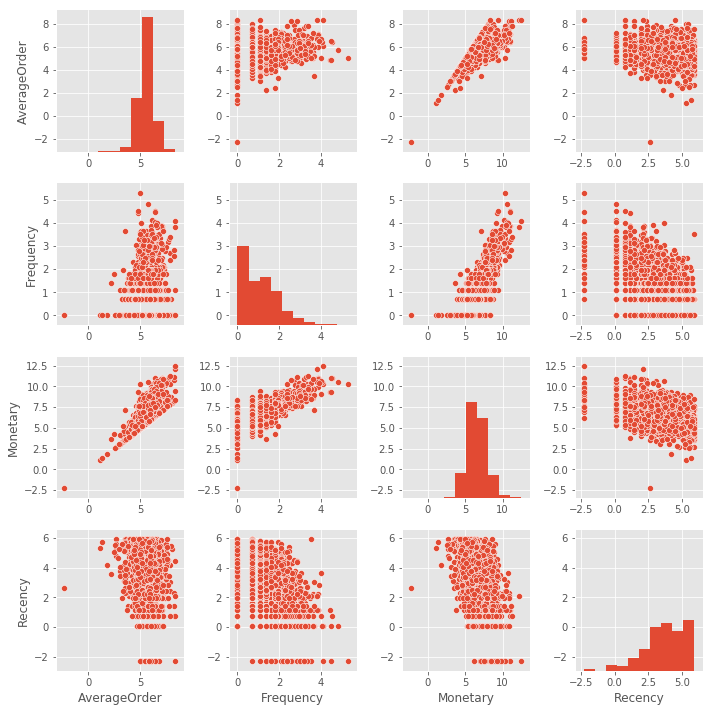

In [167]:
import seaborn as sns

sns.pairplot(log_data)

In [168]:
corr = log_data.corr()
corr.style.background_gradient()

,AverageOrder,Frequency,Monetary,Recency
AverageOrder,1,0.174419,0.70443,-0.138074
Frequency,0.174419,1,0.82176,-0.575466
Monetary,0.70443,0.82176,1,-0.494719
Recency,-0.138074,-0.575466,-0.494719,1


### Ready to begin cluster analysis

In [171]:
from sklearn.cluster import MiniBatchKMeans


X1 = log_data[['Frequency','Recency', 'Monetary']]

In [169]:
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(init='random', # initialization
        n_clusters=8,  # number of clusters
        n_init=1,       # number of different times to run k-means
        n_jobs=-1)
kmeans_mini = MiniBatchKMeans(n_clusters=8, batch_size=10)

kmeans.fit(X1)
kmeans_mini.fit(X1)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

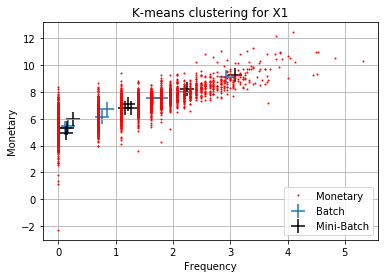

In [132]:
# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1.iloc[:, 0], X1.iloc[:, 2], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 2],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X1')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.grid()
plt.show()

In [172]:
matrix = X1.as_matrix()
for n_clusters in range(2,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.419277803941
For n_clusters = 3 The average silhouette_score is : 0.335370227372
For n_clusters = 4 The average silhouette_score is : 0.344387380159
For n_clusters = 5 The average silhouette_score is : 0.315753262516
For n_clusters = 6 The average silhouette_score is : 0.322380848887
For n_clusters = 7 The average silhouette_score is : 0.321338577649
For n_clusters = 8 The average silhouette_score is : 0.30610977588
For n_clusters = 9 The average silhouette_score is : 0.295476792537
For n_clusters = 10 The average silhouette_score is : 0.292729716232
For n_clusters = 11 The average silhouette_score is : 0.296707748236
For n_clusters = 12 The average silhouette_score is : 0.293288346554
For n_clusters = 13 The average silhouette_score is : 0.288780089501
For n_clusters = 14 The average silhouette_score is : 0.287951240061
For n_clusters = 15 The average silhouette_score is : 0.279888943928
For n_clusters = 16 The average silhouette_

In [141]:
X2 = log_data[['Recency', 'Monetary']]

# run kmeans algorithm (this is the most traditional use of k-means)
kmeans2 = KMeans(init='random', # initialization
        n_clusters=8,  # number of clusters
        n_init=1,       # number of different times to run k-means
        n_jobs=-1)
kmeans_mini2 = MiniBatchKMeans(n_clusters=8, batch_size=10)

kmeans2.fit(X2)
kmeans_mini2.fit(X2)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

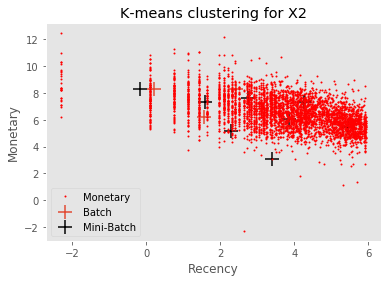

In [173]:
# visualize the data
centroids = kmeans2.cluster_centers_
plt.plot(X2.iloc[:, 0], X2.iloc[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini2.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X2')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.grid()
plt.show()

In [174]:
matrix = X2.as_matrix()
for n_clusters in range(2,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.425405428899
For n_clusters = 3 The average silhouette_score is : 0.359941118479
For n_clusters = 4 The average silhouette_score is : 0.367874715532
For n_clusters = 5 The average silhouette_score is : 0.351999856886
For n_clusters = 6 The average silhouette_score is : 0.351693903968
For n_clusters = 7 The average silhouette_score is : 0.330785223145
For n_clusters = 8 The average silhouette_score is : 0.332409249639
For n_clusters = 9 The average silhouette_score is : 0.348365097627
For n_clusters = 10 The average silhouette_score is : 0.34910319382
For n_clusters = 11 The average silhouette_score is : 0.349783615223
For n_clusters = 12 The average silhouette_score is : 0.345366095208
For n_clusters = 13 The average silhouette_score is : 0.347965912631
For n_clusters = 14 The average silhouette_score is : 0.342909516145
For n_clusters = 15 The average silhouette_score is : 0.340059335956
For n_clusters = 16 The average silhouette_

In [122]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('silhouette Score: {:<.3f}'.format(silhouette_avg))

silhouette Score: 0.500


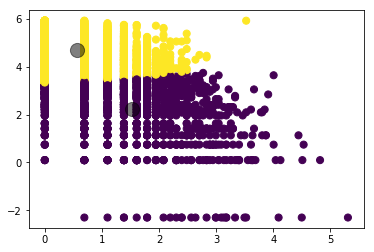

In [123]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [124]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,1,0
NumberCustomers,2382,1528


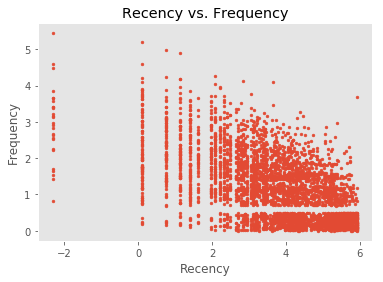

In [140]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = log_data[['Frequency','Recency','Monetary']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=8)
plt.xlabel('Recency'), plt.ylabel('Frequency')
plt.grid()
plt.title('Recency vs. Frequency')
plt.show()

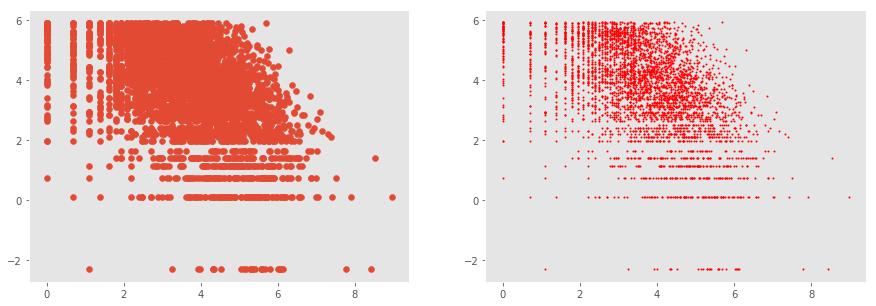

In [196]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X1[:, 0], X1[:, 1])
plt.grid()
plt.subplot(1,2,2)
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.grid()

plt.show()

In [200]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

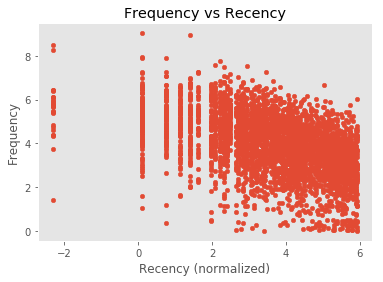

In [210]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = log_data[['Frequency','Recency']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)

plt.xlabel('Recency (normalized)'), plt.ylabel('Frequency')
plt.grid()
plt.title('Frequency vs Recency')
plt.show()


In [212]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering


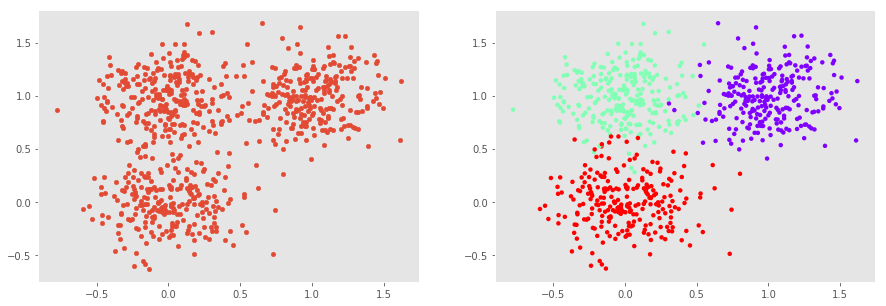

In [221]:
# Note: Just experimenting here
# Not sure that this is correct!!

from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline

# Generate sample data with labels
centers = [[1, 1], [0, 1], [0,0]]
X1, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.25)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(X1[:, 0], X1[:, 1], s=20)
plt.grid()
plt.subplot(1,2,2)
plt.scatter(X1[:, 0], X1[:, 1], c=labels_true,
                    cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.grid()
plt.show()

Estimated number of clusters: 1
Homogeneity: 0.003
Completeness: 0.018
V-measure: 0.006
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.002
Silhouette Coefficient: 0.182


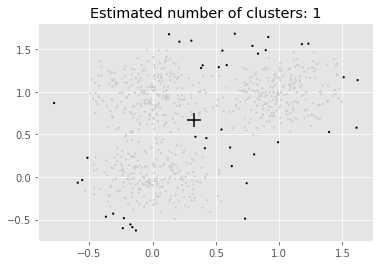

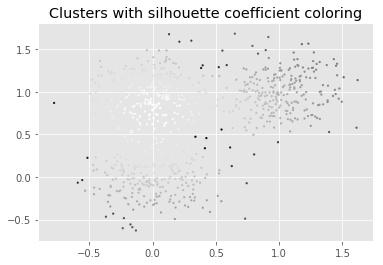

In [234]:
# Note: Just experimenting here
# Not sure that this is correct!!

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

n_clusters = 2
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(X1)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
model = DBSCAN(eps=0.15, min_samples=10).fit(X1)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X1, labels))

silhouette_per_sample = metrics.silhouette_samples(X1,labels)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):
    centroids.append( [np.mean(X1[np.where(labels==lab),0]), np.mean(X1[np.where(labels==lab),1])] )
centroids = np.array(centroids)

plt.figure()
plt.scatter(X1[:, 0], X1[:, 1], c=labels,
                    cmap=plt.cm.nipy_spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
plt.scatter(X1[:, 0], X1[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=5, linewidths=0)
plt.title('Clusters with silhouette coefficient coloring')
plt.show()

CPU times: user 16.8 ms, sys: 1.64 ms, total: 18.5 ms
Wall time: 4.6 ms


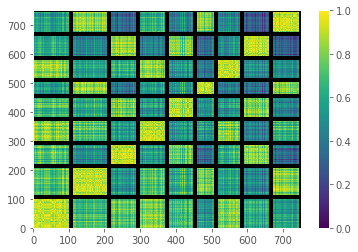

In [239]:
# Note: Just experimenting here
# Not sure that this is correct!!

# plot the similarity matrix
from sklearn.metrics import pairwise

y=labels
idx_sorted = np.argsort(y,kind="quicksort")  # need to get the ordering of Y
data_sorted = X1[idx_sorted]  # sort the dataset by class
%time R = pairwise.euclidean_distances(data_sorted)  # calculate the similarity

#transform distance to similarity
min_r = np.min(R)
max_r = np.max(R)
R = 1-(R-min_r)/(max_r-min_r)

# plt.figure(figsize=(20,10))
plt.pcolormesh(R)
plt.colorbar()

# plot class boundaries
bounds = np.cumsum([np.sum(y==val) for val in np.unique(y)])
for b in bounds:
    plt.plot([b,b],[0, len(y)],'k',linewidth=4)
    plt.plot([0, len(y)],[b,b],'k',linewidth=4)

plt.show()

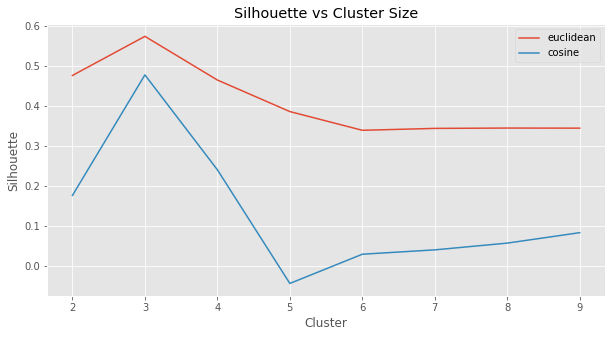

In [240]:
# Note: Just experimenting here
# Not sure that this is correct!!

# do it for the k-means
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(2,10)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X1)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(X1, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(X1, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

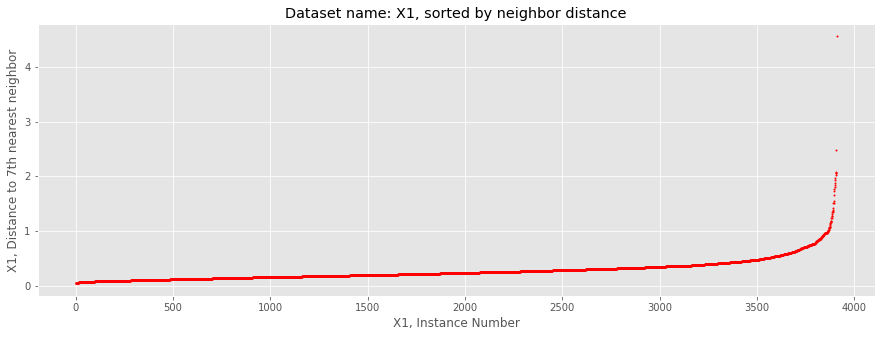

In [351]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

X1 = log_data
#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X1_N =7
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, X1_N, mode='distance') # calculate distance to four nearest neighbors 

N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N2):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)


plt.figure(figsize=(15,5))
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid(True)
plt.show()

eps is probably between 0.6 and 0.8. This estimate does not change for looking at different values of N (nearest neighbors). 


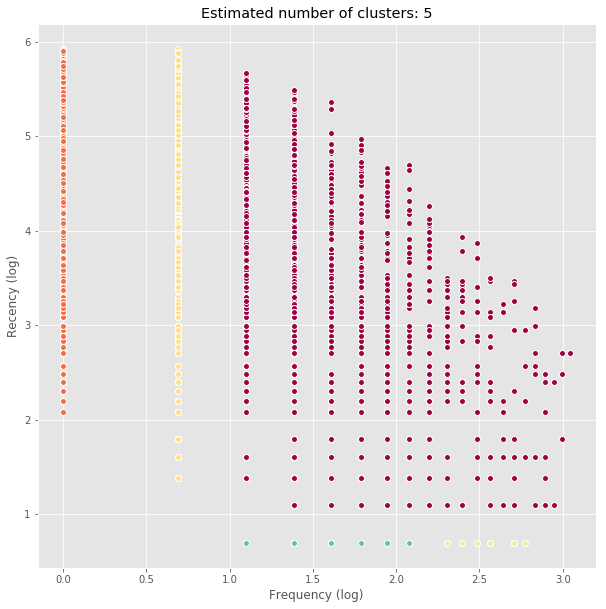

In [350]:
from sklearn.cluster import DBSCAN

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X1_minpts = 7 # from above
X1_eps = 0.4

#=====================================

for i, (data, minpts, eps) in enumerate(zip([X1],[X1_minpts],[X1_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(10,10))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy.iloc[:, 1], xy.iloc[:,3 ], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
       # xy = data[class_member_mask & ~core_samples_mask]
        #plt.plot(xy.iloc[:, 1], xy.iloc[:, 3], 'o', markerfacecolor=col,
              #   markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.xlabel('Frequency (log)')
    plt.ylabel('Recency (log)')
    plt.grid(True)
    plt.show()

As a reminder, Frequency is equivalent to the number of orders a customer has placed, and we have taken the log of these values. 
* In this clustering, there is a cluster along x=0, which is equivalent to customers have placed one order. Most of these customers have not ordered in the last week of our data set ((e^2.1)-1=~7). 
* The next cluster, along x=0.7, represents customers who have placed two orders, and most of these orders were also placed longer than a week ago.
* The third cluster represents customers who have placed 3 or more orders, the latest of which was placed the day before the end of our study period.
* The fourth cluster represents customers who have placed 14 or more orders, the latest of which was placed the day before the end of our study period.
* The majority of customers fall into the largest cluster of customers who have made more than three orders, and their latest order was at least 2 days befor the end of our study period. 
